In [1]:
from __future__ import division
from pyomo.environ import *
from pyomo.opt import SolverFactory
import pyomo.environ as pyo
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
from collections import defaultdict
import math
import requests
from amplpy import modules
import random


In [2]:
# Definir el solver como CouenneS
solver_name = "coin"
solver = SolverFactory(solver_name+"nl", executable="couenne", solve_io="nl")

In [3]:
def leer_nodos(depot_file, client_file):
    nodos = defaultdict(dict)

    with open(depot_file, mode='r') as depots_csv:
        depots_reader = csv.DictReader(depots_csv)
        for row in depots_reader:
            location_id = int(row["LocationID"])
            # Agregar información del depósito
            nodos[location_id].update({
                "DepotID": int(row["DepotID"]),
                "Longitude": float(row["Longitude"]),
                "Latitude": float(row["Latitude"])
            })

    with open(client_file, mode='r') as clients_csv:
        clients_reader = csv.DictReader(clients_csv)
        for row in clients_reader:
            location_id = int(row["LocationID"])

            nodos[location_id].update({
                "ClientID": int(row["ClientID"]),
                "Product-Type-A": int(row["Product-Type-A"]),
                "Product-Type-B": int(row["Product-Type-B"]),
                "Product-Type-C": int(row["Product-Type-C"]),
                "Longitude": float(row["Longitude"]),
                "Latitude": float(row["Latitude"])
            })
    
    return dict(nodos)

nodos = leer_nodos("Depots.csv", "Clients.csv")
print(nodos)

{1: {'DepotID': 1, 'Longitude': -74.08124218159384, 'Latitude': 4.75021190869025}, 2: {'DepotID': 2, 'Longitude': -74.10993358606953, 'Latitude': 4.5363832206427785}, 3: {'DepotID': 3, 'Longitude': -74.03854814565923, 'Latitude': 4.792925960208614}, 4: {'DepotID': 4, 'Longitude': -74.06706883098641, 'Latitude': 4.72167778077445}, 5: {'DepotID': 5, 'Longitude': -74.13826337931849, 'Latitude': 4.607707046760958}, 6: {'DepotID': 6, 'Longitude': -74.12400186370824, 'Latitude': 4.650463053612691}, 7: {'DepotID': 7, 'Longitude': -74.09561875464892, 'Latitude': 4.621911772492814}, 8: {'DepotID': 8, 'Longitude': -74.10975623736951, 'Latitude': 4.678960680833056}, 9: {'DepotID': 9, 'Longitude': -74.09547235719887, 'Latitude': 4.735973062153282}, 10: {'DepotID': 10, 'Longitude': -74.10991610076434, 'Latitude': 4.550640992537941}, 11: {'DepotID': 11, 'Longitude': -74.10977422186991, 'Latitude': 4.664702960902753}, 12: {'DepotID': 12, 'Longitude': -74.12408925943333, 'Latitude': 4.5791740634103135

In [4]:
def leer_vehiculos_csv(file_path):
    multi_vehicles = []
    vehicle_type_mapping = {"Gas Car": 1, "EV": 3, "drone": 2}
    with open(file_path, "r") as file:
        reader = csv.DictReader(file)
        for row in reader:
            vehicle_type = vehicle_type_mapping.get(row["VehicleType"], 0)  # 0 si no está en el mapeo
            capacity = float(row["Capacity"])
            range_ = float(row["Range"])
            multi_vehicles.append([vehicle_type, capacity, range_])
    return multi_vehicles

vehiculos = leer_vehiculos_csv("Vehicles.csv")
print(vehiculos)



[[1, 197.88170950840438, 145.85207096486445], [3, 135.54452491441663, 1304.605971281605], [3, 114.38031900663994, 953.1726086101639], [2, 52.63370252405913, 17.302304187458727], [2, 36.24420491252038, 16.627680130757895], [2, 36.2926584575003, 13.602810739289229]]


In [5]:
def cargar_datos_vehiculos(filepath):
    vehiculos = {}

    tipo_vehiculo_map = {'Gas Car': 1,'Drone': 2,'Solar EV': 3}
    with open(filepath, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            tipo_vehiculo = row['Vehicle']
            numero_vehiculo = tipo_vehiculo_map.get(tipo_vehiculo)
            if numero_vehiculo:
                vehiculos[numero_vehiculo] = {
                    'Freight Rate': float(row['Freight Rate [COP/km]']) if row['Freight Rate [COP/km]'] else 0.0,
                    'Time Rate': float(row['Time Rate [COP/min]']) if row['Time Rate [COP/min]'] else 0.0,
                    'Daily Maintenance': float(row['Daily Maintenance [COP/day]']) if row['Daily Maintenance [COP/day]'] else 0.0,
                    'Recharge/Fuel Cost': float(row['Recharge/Fuel Cost [COP/(gal or kWh)]']) if row['Recharge/Fuel Cost [COP/(gal or kWh)]'] else 0.0,
                    'Recharge/Fuel Time': float(row['Recharge/Fuel Time [min/10 percent charge]']) if row['Recharge/Fuel Time [min/10 percent charge]'] else 0.0,
                    'Avg. Speed': float(row['Avg. Speed [km/h]']) if row['Avg. Speed [km/h]'] else 0.0,
                    'Gas Efficiency': float(row['Gas Efficiency [km/gal]']) if row['Gas Efficiency [km/gal]'] else 0.0,
                    'Electricity Efficiency': float(row['Electricity Efficency [kWh/km]']) if row['Electricity Efficency [kWh/km]'] else 0.0
                }
    return vehiculos

datos_vehiculos = cargar_datos_vehiculos('vehicles_data.csv')
print(datos_vehiculos)

{1: {'Freight Rate': 5000.0, 'Time Rate': 500.0, 'Daily Maintenance': 30000.0, 'Recharge/Fuel Cost': 16000.0, 'Recharge/Fuel Time': 0.1, 'Avg. Speed': 0.0, 'Gas Efficiency': 10.0, 'Electricity Efficiency': 0.0}, 2: {'Freight Rate': 500.0, 'Time Rate': 500.0, 'Daily Maintenance': 3000.0, 'Recharge/Fuel Cost': 220.73, 'Recharge/Fuel Time': 2.0, 'Avg. Speed': 40.0, 'Gas Efficiency': 0.0, 'Electricity Efficiency': 0.15}, 3: {'Freight Rate': 4000.0, 'Time Rate': 500.0, 'Daily Maintenance': 21000.0, 'Recharge/Fuel Cost': 0.0, 'Recharge/Fuel Time': 0.0, 'Avg. Speed': 0.0, 'Gas Efficiency': 0.0, 'Electricity Efficiency': 0.15}}


In [6]:
import csv

def cargar_Depot_Capacities(filepath):
    depot_capacities = {}
    with open(filepath, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            depot_id = int(row['DepotID'])

            # Almacenar las capacidades para cada tipo de producto
            depot_capacities[depot_id] = {
                "Product-Type-A": float(row['Product-Type-A']),
                "Product-Type-B": float(row['Product-Type-B']),
                "Product-Type-C": float(row['Product-Type-C'])
            }
    return depot_capacities

# Ejemplo de uso
depot_capacities = cargar_Depot_Capacities('DepotCapacities.csv')
print(depot_capacities)


{1: {'Product-Type-A': 14.0, 'Product-Type-B': 2.0, 'Product-Type-C': 5.0}, 2: {'Product-Type-A': 16.0, 'Product-Type-B': 0.0, 'Product-Type-C': 2.0}, 3: {'Product-Type-A': 24.0, 'Product-Type-B': 2.0, 'Product-Type-C': 3.0}, 4: {'Product-Type-A': 16.0, 'Product-Type-B': 5.0, 'Product-Type-C': 1.0}, 5: {'Product-Type-A': 7.0, 'Product-Type-B': 0.0, 'Product-Type-C': 4.0}, 6: {'Product-Type-A': 14.0, 'Product-Type-B': 5.0, 'Product-Type-C': 8.0}, 7: {'Product-Type-A': 17.0, 'Product-Type-B': 6.0, 'Product-Type-C': 2.0}, 8: {'Product-Type-A': 3.0, 'Product-Type-B': 1.0, 'Product-Type-C': 0.0}, 9: {'Product-Type-A': 6.0, 'Product-Type-B': 2.0, 'Product-Type-C': 2.0}, 10: {'Product-Type-A': 3.0, 'Product-Type-B': 0.0, 'Product-Type-C': 1.0}, 11: {'Product-Type-A': 26.0, 'Product-Type-B': 0.0, 'Product-Type-C': 1.0}, 12: {'Product-Type-A': 12.0, 'Product-Type-B': 1.0, 'Product-Type-C': 7.0}}


In [7]:
def obtener_distancia_y_tiempo(origen, destino):
    inicio = "{},{}".format(origen[0], origen[1])
    fin = "{},{}".format(destino[0], destino[1])
    url = f'http://router.project-osrm.org/route/v1/driving/{inicio};{fin}?alternatives=false&overview=false'

    headers = {'Content-Type': 'application/json'}
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        route_json = response.json()
        total_distance_meters = route_json['routes'][0]['distance']
        total_duration_seconds = route_json['routes'][0]['duration']
        distancia_km = total_distance_meters / 1000
        tiempo_horas = total_duration_seconds / 3600
        return distancia_km, tiempo_horas
    else:
        raise Exception(f"Error en la llamada a la API: {response.status_code}")


In [8]:
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    r = 6371 
    return r * c

In [9]:
# extract coordinates

nodos_coords = {k: [v['Longitude'], v['Latitude']] for k, v in nodos.items()}

# Combine depots and clients
all_coords = list(nodos_coords.values())

# Build the coordinates string for OSRM
coords_str = ';'.join([f"{lon},{lat}" for lon, lat in all_coords])

# API URL
url = f"https://router.project-osrm.org/table/v1/driving/{coords_str}"

# Parameters
params = {
    'sources': ';'.join(map(str, range(len(all_coords)))),
    'destinations': ';'.join(map(str, range(len(all_coords)))),
    'annotations': 'duration,distance'
}

# Send the request
response = requests.get(url, params=params)

# Check for successful response
if response.status_code != 200:
    print(f"Error: {response.status_code}")
    print(response.text)
    exit()

data = response.json()

# Extract the distance matrix
distance_matrix_osrm = np.array(data['distances'])

# Extract the duration matrix
duration_matrix_osrm = np.array(data['durations'])


In [10]:

def calcular_matrices_haversine(nodos_coords, velocidad_promedio):
    """

    """
    all_coords = list(nodos_coords.values())
    num_nodos = len(all_coords)

    # Inicializar matrices
    distance_matrix = np.zeros((num_nodos, num_nodos))
    duration_matrix = np.zeros((num_nodos, num_nodos))

    for i in range(num_nodos):
        for j in range(num_nodos):
            if i == j:
                distance_matrix[i][j] = 0
                duration_matrix[i][j] = 0
            else:
                # Extraer coordenadas
                lon1, lat1 = all_coords[i]
                lon2, lat2 = all_coords[j]
                # Calcular distancia
                distancia = haversine(lat1, lon1, lat2, lon2)
                distance_matrix[i][j] = distancia
                # Calcular duración
                duration_matrix[i][j] = distancia / velocidad_promedio * 60  # Minutos

    return distance_matrix, duration_matrix

# Ejemplo de uso
nodos_coords = {k: [v['Longitude'], v['Latitude']] for k, v in nodos.items()}
velocidad_promedio = datos_vehiculos[2]['Avg. Speed']

distance_matrix_haversine, duration_matrix_haversine = calcular_matrices_haversine(nodos_coords, velocidad_promedio)



In [11]:

# Imprimir la matriz con los índices al final
print("Matriz de Distancias (OSRM) con índices:")
for i, row in enumerate(duration_matrix_osrm):
    print(f"Fila {i}: {row.tolist()} (Índice i: {i})")


Matriz de Distancias (OSRM) con índices:
Fila 0: [0.0, 2508.2, 1053.9, 691.9, 1741.4, 1355.2, 1440.3, 877.0, 381.9, 2342.4, 1139.1, 1998.8, 1700.0, 761.6, 855.2, 761.6, 1726.5, 1498.0, 353.2, 927.1, 2048.0] (Índice i: 0)
Fila 1: [2502.5, 0.0, 2537.1, 2135.8, 1304.9, 1508.3, 1256.4, 1855.4, 2297.0, 270.3, 1643.0, 853.1, 1373.1, 2161.1, 2237.6, 2129.8, 1566.7, 1427.9, 2377.2, 2088.8, 778.6] (Índice i: 1)
Fila 2: [1188.2, 3179.2, 0.0, 1329.7, 2603.8, 2184.6, 2205.5, 1763.8, 1495.8, 3013.4, 1913.7, 2669.8, 2660.1, 1728.0, 1804.5, 1377.9, 2686.6, 2313.9, 1467.1, 1361.5, 2719.0] (Índice i: 2)
Fila 3: [564.0, 2141.6, 794.3, 0.0, 1513.2, 1094.0, 1167.9, 748.1, 502.8, 1975.8, 898.0, 1632.2, 1644.4, 712.3, 788.8, 295.1, 1670.9, 1223.3, 583.0, 460.6, 1681.4] (Índice i: 3)
Fila 4: [1565.2, 1302.0, 1784.6, 1198.5, 0.0, 395.1, 544.3, 918.1, 1359.7, 1125.7, 785.9, 598.2, 764.5, 1223.8, 1300.3, 1192.5, 865.8, 393.7, 1439.9, 1355.3, 982.4] (Índice i: 4)
Fila 5: [1220.6, 1505.2, 1479.6, 853.9, 657.9, 0.

In [12]:
def leer_ultimos_location_ids(depot_file, client_file):
    last_depot_location_id = None
    last_client_location_id = None

    # Leer el archivo de depósitos
    with open(depot_file, mode='r') as depots_csv:
        depots_reader = csv.DictReader(depots_csv)
        for row in depots_reader:
            last_depot_location_id = int(row["LocationID"])

    # Leer el archivo de clientes
    with open(client_file, mode='r') as clients_csv:
        clients_reader = csv.DictReader(clients_csv)
        for row in clients_reader:
            last_client_location_id = int(row["LocationID"])
    
    return last_depot_location_id, last_client_location_id

# Llamar a la función y obtener los resultados
last_depot, last_client = leer_ultimos_location_ids("Depots.csv", "Clients.csv")
print(f"Último LocationID de Depots: {last_depot}")
print(f"Último LocationID de Clients: {last_client}")

Último LocationID de Depots: 12
Último LocationID de Clients: 21


In [13]:
def obtener_valor_tiempo(vehiculo,i, j):

    if vehiculo not in [1, 2, 3]:
        raise ValueError("El vehículo debe ser 1, 2 o 3.")

    # Vehículos 1 y 3 usan OSRM
    if vehiculo in [1, 3]:
        return duration_matrix_osrm[i][j]/60  # Retornar duración de OSRM
    # Vehículo 2 usa Haversine
    elif vehiculo == 2:
        return duration_matrix_haversine[i][j]  # Retornar duración de Haversine
    

def obtener_valor_distancia(vehiculo,i, j):

    if vehiculo not in [1, 2, 3]:
        raise ValueError("El vehículo debe ser 1, 2 o 3.")
    if vehiculo in [1, 3]:
        return distance_matrix_osrm[i][j] /1000 # Retornar distancia de OSRM
    # Vehículo 2 usa Haversine
    elif vehiculo == 2:
        return distance_matrix_haversine[i][j]  # Retornar distancia de Haversine

In [14]:
def calcular_costo_combustible(vehiculo, distancia_recorrida):
    tipo = vehiculos[vehiculo][0]
    if tipo not in [1, 2]:  # Validar tipo de vehículo
        return 0

    # Datos del vehículo
    datos = datos_vehiculos[tipo]

    eficiencia = datos['Gas Efficiency'] if tipo == 1 else datos['Electricity Efficiency']
    # Cálculos de consumo y tiempo de carga
    cantidad_total = distancia_recorrida / eficiencia
    energia_10 = cantidad_total * 0.1
    tiempo_carga = energia_10 / datos['Recharge/Fuel Time']
    
    # Costo total
    return (cantidad_total * datos['Recharge/Fuel Cost'] +
            tiempo_carga * datos['Time Rate'])


In [15]:
def costo_mantenimiento(tipo_vehiculo):
    # Costo de mantenimiento depende del tipo de vehículo
    if tipo_vehiculo not in datos_vehiculos:
        return 0
    return datos_vehiculos[tipo_vehiculo]['Daily Maintenance']


In [16]:
def calcular_costo_operativo(tipo_vehiculo, i, j):
    if tipo_vehiculo not in datos_vehiculos:
        return 0
    distancia = obtener_valor_distancia(tipo_vehiculo, i, j)
    tiempo = obtener_valor_tiempo(tipo_vehiculo, i, j)
    return (
        tiempo * datos_vehiculos[tipo_vehiculo]['Time Rate'] +
        distancia * datos_vehiculos[tipo_vehiculo]['Freight Rate']
    )


In [17]:
def calcular_costo_producto_a(j):
    # Costo por producto tipo A
    if j <= last_depot:  # Si el nodo es un depósito, no hay costo
        return 0
    return 500 * (nodos[j]['Product-Type-A'] / 5)

def calcular_costo_producto_b(j):
    # Costo por producto tipo B
    if j <= last_depot:  # Si el nodo es un depósito, no hay costo
        return 0
    return 500 * (nodos[j]['Product-Type-B'] / 5)

def calcular_costo_producto_c(j):
    # Costo por producto tipo C
    if j <= last_depot:  # Si el nodo es un depósito, no hay costo
        return 0
    return 500 * (nodos[j]['Product-Type-C'] / 5)

In [ ]:

Modelo = ConcreteModel()

#--------------------- Conjuntos  & Parámetros --------------------------#

depots_nodos = range(1, last_depot + 1)
clients_nodos = range(last_depot+1, last_client+1)
nodos_range = range(1, last_client+1)
vehicles_range = range(len(vehiculos))

#--------------------- Parámetros --------------------------#
Modelo.x = Var(nodos,nodos, vehicles_range, within=Binary)

Modelo.u = Var(nodos,vehicles_range, within=NonNegativeReals)

#--------------------- Función Objetivo --------------------------#

# Función Objetivo Mejorada
Modelo.obj = Objective(expr = sum(
    Modelo.x[i, j, k] * (
        # Costo de combustible
        calcular_costo_combustible(k,obtener_valor_distancia(vehiculos[k][0], i - 1, j - 1)) +
        calcular_costo_operativo(vehiculos[k][0], i - 1, j - 1)+
        # Costo de carga
        calcular_costo_producto_a(j) +
        calcular_costo_producto_b(j) +
        calcular_costo_producto_c(j)
    ) 

    for i in nodos_range for j in nodos_range for k in vehicles_range
    )    
    + 
    sum(
        datos_vehiculos[vehiculos[k][0]]['Daily Maintenance']
        for k in vehicles_range))


#--------------------- Restricciones --------------------------#

# Restricción 1: No se puede ir de un nodo a sí mismo
def no_self_route(Modelo, i, k):
    return Modelo.x[i,i,k] == 0

Modelo.no_self_route = Constraint(nodos_range, vehicles_range, rule=no_self_route)

# Restricción 2: Cada nodo debe ser visitado exactamente una vez
def visit_once(Modelo, i):
    return sum(Modelo.x[i,j,k] for j in nodos_range for k in vehicles_range) == 1

Modelo.visit_once = Constraint(clients_nodos, rule=visit_once)

# Restricción 3: Restricción de flujo
def depot_flow(Modelo,i, k):
    return sum(Modelo.x[i,j,k] for j in nodos_range) == sum(Modelo.x[j,i,k] for j in nodos_range)

Modelo.depot_flow = Constraint(clients_nodos,vehicles_range, rule=depot_flow)



# Restricción 4: Eliminación de subtours
def subtour_elimination(Modelo, i, j, k):
    if i != j :
        return Modelo.u[i,k] - Modelo.u[j,k] + len(nodos)*Modelo.x[i,j,k] <= len(nodos) - 1
    else:
        return Constraint.Skip

Modelo.subtour_elimination = Constraint(clients_nodos, clients_nodos, vehicles_range, rule=subtour_elimination)

# Restricción 5: La distancia máxima que puede recorrer un vehículo
def max_distance(Modelo,i,j, k):
    return Modelo.x[i, j, k] * obtener_valor_distancia(vehiculos[k][0], i-1, j-1) <= vehiculos[k][2]

Modelo.max_distance = Constraint(nodos_range,clients_nodos,vehicles_range, rule=max_distance)

def max_capacity(Modelo, k):
    return sum(
        sum(Modelo.x[i, j, k] * (nodos[j]['Product-Type-A'] + nodos[j]['Product-Type-B'] + nodos[j]['Product-Type-C']) for i in nodos_range)
        for j in clients_nodos
    ) <= vehiculos[k][1]  # Vehículo k tiene una capacidad máxima vehiculos[k][1]

Modelo.max_capacity = Constraint(vehicles_range, rule=max_capacity)

#Restricción 7: Todos los vehiculos deben regresar de un deposito
def return_depot(Modelo, k):
    return sum(Modelo.x[i, j, k] for i in nodos_range for j in depots_nodos) == 1

Modelo.return_depot = Constraint(vehicles_range, rule=return_depot)

#Restricción 7: Todos los vehiculos deben regresar de un deposito
def return_depot(Modelo, k):
    return sum(Modelo.x[i, j, k] for i in depots_nodos for j in nodos_range) == 1

Modelo.return_depot = Constraint(vehicles_range, rule=return_depot)

#Restriccion 8: Los vehiculos no pueden viajar de un deposito a otro
def no_depot_to_depot(Modelo, k):
    return sum(Modelo.x[i, j, k] for i in depots_nodos for j in depots_nodos) == 0

Modelo.no_depot_to_depot = Constraint(vehicles_range, rule=no_depot_to_depot)



# Restricción de capacidad de depósito: Un depósito no puede entregar más productos de los que tiene
def max_capacity_depot(Modelo, p):
    return (
        sum(
            sum(
                sum(Modelo.x[i, j, k] * (nodos[j]['Product-Type-A'] + nodos[j]['Product-Type-B'] + nodos[j]['Product-Type-C']) for i in nodos_range)
                for j in clients_nodos
            )
            * sum(Modelo.x[p, i, k] for i in clients_nodos)
            for k in vehicles_range
        ) <= (depot_capacities[p]['Product-Type-A']+ depot_capacities[p]['Product-Type-B']+  depot_capacities[p]['Product-Type-C'])
    )

Modelo.max_capacity_depot = Constraint(depots_nodos, rule=max_capacity_depot)


solver.solve(Modelo, tee=True)
Modelo.display()


(type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown
with a new Component (type=<class
'pyomo.core.base.constraint.IndexedConstraint'>). This is usually indicative
of a modelling error. To avoid this warning, use block.del_component() and
block.add_component().
Couenne 0.5.8 -- an Open-Source solver for Mixed Integer Nonlinear Optimization
Mailing list: couenne@list.coin-or.org
Instructions: http://www.coin-or.org/Couenne
couenne: 
ANALYSIS TEST: Reformulating problem: 0.2 seconds
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT 256804.13       45 5.704
NLP0014I             2      INFEAS 4.9999367       17 1.857
Loaded instance "C:\Users\Admin\AppData\Local\Temp\tmphio0nckg.pyomo.nl"
Constraints:         1785
Variables:           2700 (2646 integer)
Auxiliaries:          562 (168 integer)

Coin0506I Presolve 811 (-355) rows, 1215 (-2047) columns and 6686 (-6901) elements
Clp0

In [ ]:
nombre_grupo = "Grupo 7"  
tipo_caso = "Manejo de Múltiples Productos"  
numero_caso = 4  
nombre_archivo = f"{nombre_grupo}-caso-{tipo_caso}-{numero_caso}-ruta.csv"

with open(nombre_archivo, mode='w', newline='') as archivo_csv:
    writer = csv.writer(archivo_csv)
    writer.writerow(["ID-Vehiculo", "ID-Origen", "ID-Destino"])
    for i in nodos: 
        for j in nodos:  
            for k in vehicles_range:  
                if np.round(Modelo.x[i, j, k].value) == 1:
                    writer.writerow([f"V{k+1}", f"N{i}", f"N{j}"])

# Imprimir el valor de la función objetivo
objetivo = next(Modelo.component_objects(Objective, active=True)) 
valor_objetivo = objetivo.expr()  
print(f"Valor de la función objetivo: {valor_objetivo}")


ERROR: evaluating object as numeric value: x[1,1,0]
        (object: <class 'pyomo.core.base.var.VarData'>)
    No value for uninitialized NumericValue object x[1,1,0]


ValueError: No value for uninitialized NumericValue object x[1,1,0]

In [ ]:
nombre_archivo_objetivo = f"{tipo_caso.capitalize()}{numero_caso} Objetivo.txt"

objetivo = next(Modelo.component_objects(Objective, active=True))  
valor_objetivo = objetivo.expr()  

with open(nombre_archivo_objetivo, mode='w') as archivo_objetivo:
    archivo_objetivo.write(f"Valor de la función objetivo: {valor_objetivo}\n")

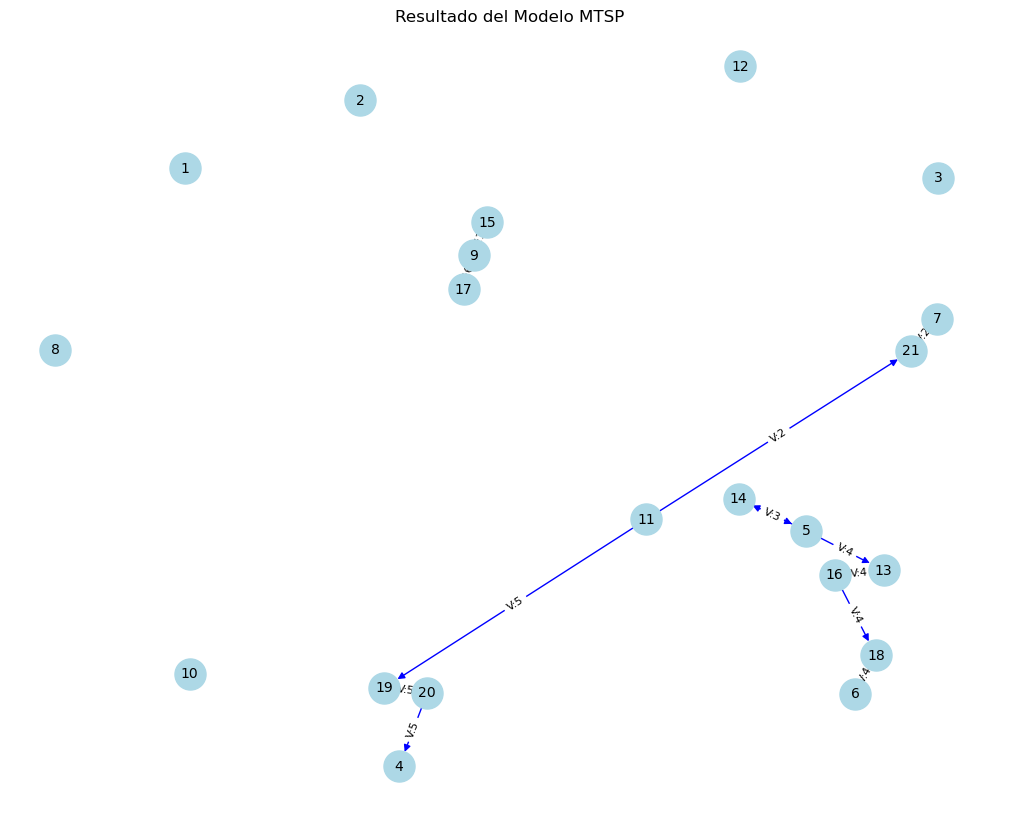

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def crearGrafo(Modelo):
    """
    Crear un grafo dirigido a partir de las variables de decisión de un modelo.
    """
    grafo = nx.DiGraph()

    # Agregar nodos al grafo
    for i in nodos:
        grafo.add_node(i)
    
    # Agregar aristas al grafo basadas en las soluciones del modelo
    for i in nodos:
        for j in nodos:
            for k in vehicles_range:
                if np.round(Modelo.x[i, j, k].value) == 1:
                    grafo.add_edge(i, j, color='blue', label=f'V:{k+1}')
    
    return grafo


def graficarMTSP(Modelo):
    """
    Graficar el grafo resultante del modelo MTSP.
    """
    grafo = crearGrafo(Modelo)
    pos = nx.spring_layout(grafo)  # Layout del grafo

    # Colores de las aristas según el vehículo
    edges = grafo.edges(data=True)
    colors = [edata['color'] for _, _, edata in edges]
    labels = {(u, v): data['label'] for u, v, data in edges if 'label' in data}
    # Crear figura
    plt.figure(figsize=(10, 8))
    nx.draw(
        grafo, pos, edge_color=colors, with_labels=True, 
        node_size=500, node_color='lightblue', font_size=10
    )
    nx.draw_networkx_edge_labels(grafo, pos, edge_labels=labels, font_size=8)
    plt.title("Resultado del Modelo MTSP")
    plt.show()

# Llamada a la función para graficar
graficarMTSP(Modelo)
